In [18]:
import os
import json
import skimage
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt

### Set config

In [19]:
config_filename = 'demo_config.json'
debug = True

In [20]:
cresi_dir = '/opt/cresi'
%cd {cresi_dir}

/opt/cresi


In [21]:
src_dir = os.path.join(cresi_dir, 'cresi')
config_dir = os.path.join(cresi_dir, src_dir, 'configs')
weight_dir = os.path.join(cresi_dir, src_dir, config_dir, 'weights')

data_dir  = os.path.join(cresi_dir, 'data')
raw_data_dir = os.path.join(cresi_dir, data_dir, 'raw_data')
eight_bit_dir = os.path.join(cresi_dir, data_dir, '8bit_data')
sliced_dir = os.path.join(cresi_dir, data_dir, 'sliced_data')

results_dir = os.path.join(cresi_dir, 'results')
mask_pred_dir = os.path.join(results_dir, 'folds')
mask_stitched_dir = os.path.join(results_dir, 'stitched/mask_norm')

# make dirs
#for d in [weight_dir, test_im_raw_dir, test_im_clip_dir, test_final_dir, mask_stitched_dir, mask_pred_dir]:
#    os.makedirs(d, exist_ok=True)

In [22]:
config_path = os.path.join(config_dir, config_filename)

# update directories
with open(config_path, 'r+') as f:
    data = json.load(f)
    data['path_src'] = src_dir
    data['path_data_root'] = data_dir
    data['path_results_root'] = results_dir
    data['results_dir'] = results_dir # TODO
    data['save_weights_dir'] = weight_dir
    
    data['eight_bit_dir'] = eight_bit_dir
    data['sliced_dir'] = sliced_dir

In [23]:
# write new values
os.remove(config_path)
with open(config_path, 'w') as f:
    json.dump(data, f, indent=4)

### Convert 16bit MS to 8bit, 3 band

In [ ]:
#import rasterio 
"""
for im_name in os.listdir(test_im_clip_dir):
    break
    ds = rasterio.open(os.path.join(test_im_clip_dir, im_name))

    n_ds = rasterio.open(
        os.path.join(test_final_dir, im_name),
        'w',
        driver='GTiff',
        height=ds.shape[0],
        width=ds.shape[1],
        count=3, # 3 bands
        dtype='uint8', # 8 bit
        crs=ds.crs, # copy from orig
        transform=ds.transform # lonlat bounds, copy from orig
    )
    
    # 3 band orig
    if len(ds.dtypes) == 3:
        n_ds.write_band(1, ds.read(1).astype('uint8'))
        n_ds.write_band(2, ds.read(2).astype('uint8'))
        n_ds.write_band(3, ds.read(3).astype('uint8'))
    elif len(ds.dtypes) == 8:
        n_ds.write_band(1, ds.read(5).astype('uint8'))
        n_ds.write_band(2, ds.read(3).astype('uint8'))
        n_ds.write_band(3, ds.read(2).astype('uint8'))
    else:
        print ('Unknown source type.')
    
    n_ds.close()
"""
 

In [ ]:
# this works much better, but we can't use gdal 
from cresi import create_8bit_images

# Convert 16-bit multispectral test data to 8-bit RGB
create_8bit_images.dir_to_8bit(raw_data_dir, eight_bit_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[]) # specify [5,3,2] if MS channels. Here we are using RGB itself

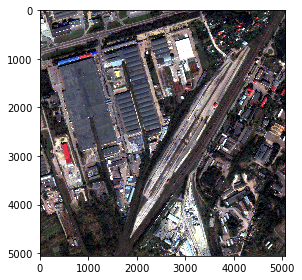

In [24]:
# display our image
im_name = [z for z in os.listdir(eight_bit_dir) if z.endswith('.tif')][0]
im_path = os.path.join(eight_bit_dir, im_name)
im = skimage.io.imread(im_path)

skimage.io.imshow(im) 
skimage.io.show()

### Slice image into processable chunks
slice_x, slice_y defined in config

In [ ]:
%run -i cresi/01_slice.py { config_path }

Executing tile_im.py..
slice command: python /opt/cresi/cresi/data_prep/tile_im.py /opt/cresi/cresi/configs/demo_config.json


### Run Inference

In [ ]:
%run -i cresi/02_eval.py { config_path }

### Evaluate results

The 02_eval.py script produce a multi-channel road masks for each image tile.  Each channel of this mask corresponds to a unique speed range.  For each of the testing tiles, the predicted mask will look something like the plot below.

In [12]:
mask_pred_file = [z for z in os.listdir(mask_pred_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_pred_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

IndexError: list index out of range

### Stitch slices back together

In [ ]:
%run -i cresi/03_stitch.py { config_path }

In [ ]:
# Inspect the output
plot_all_layers = False
mask_pred_file = [z for z in os.listdir(mask_stitched_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_stitched_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

# plot all layers (optional)
if plot_all_layers:
    fig, axes = plt.subplots(2, 4, figsize=(20, 11))
    for i, ax in enumerate(axes.flatten()):
        if i < (len(axes.flatten()) - 1):
            title = 'Mask Channel {}'.format(str(i))
        else:
            title = 'Aggregate' 
        ax.imshow(mask_pred[i,:,:])
        ax.set_title(title)

-----
The 04_skeletonize script creates a graph from the aggregate mask via a multi-step process:
    
1. Refine aggregate mask via smoothing, openings, and closings.

2. Extract a skeleton of the refined mask.

3. Build a graph from the skeleton.  

4. Clean out spurious edges and complete missing connections.

5. Output a csv of graph edges.  This csv output is included as a convenient intermediate step, since if speeds and geographic coordinates are not required we can forego Sections 5.4 and 5.5.

The 04_skeletonize.py script is multi-threaded to improve speed

In [ ]:
%run -i cresi/04_skeletonize.py { config_path }

In [ ]:
# inspect the output
csv_path = os.path.join(results_dir, 'wkt_submission_nospeed.csv')
df = pd.read_csv(csv_path)
df.head()

-----
### 5.4. 05_wkt_to_G.py

This script reads the csv output by 04_skeletonize.py back into graph format (which is very quick), and then uses the metadata encoded in our geotiff test image to assign geographic coordinates to the graph.  Assigning geo-coordinates for thousands of nodes is a computationally intensive process, so this script is multi-threaded to improve performance. The script outputs a [NetworkX](https://networkx.github.io) graph structure in ~60 seconds.

In [ ]:
%run -i cresi/05_wkt_to_G.py { config_path }

In [ ]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, figsize=(12,12))

In [ ]:
!pip install simplekml

In [ ]:
from __future__ import print_function
import os
import utm
import shapely.wkt
import shapely.ops
from shapely.geometry import mapping, Point, LineString
import fiona
import networkx as nx
import osmnx as ox
from osgeo import gdal, ogr, osr
import argparse
import json
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import logging
from multiprocessing.pool import Pool


In [ ]:
orig_img = os.path.join(eight_bit_dir, gpickle_path.split('/')[-1].split('.')[0] + '.tif')
orig_img

In [ ]:
###############################################################################
def pixelToGeoCoord(params):
    """from spacenet geotools"""
    # lon, lat = pixelToGeoCoord(x_pix, y_pix, im_file, targetSR=targetSR)
    #         params.append((x_pix, y_pix, im_file, targetSR))

    sourceSR = ""
    geomTransform = ""
    targetSR = osr.SpatialReference()
    targetSR.ImportFromEPSG(4326)

    identifier, xPix, yPix, inputRaster = params

    if targetSR == "":
        performReprojection = False
        targetSR = osr.SpatialReference()
        targetSR.ImportFromEPSG(4326)
    else:
        performReprojection = True

    if geomTransform == "":
        srcRaster = gdal.Open(inputRaster)
        geomTransform = srcRaster.GetGeoTransform()

        source_sr = osr.SpatialReference()
        source_sr.ImportFromWkt(srcRaster.GetProjectionRef())

    geom = ogr.Geometry(ogr.wkbPoint)
    xOrigin = geomTransform[0]
    yOrigin = geomTransform[3]
    pixelWidth = geomTransform[1]
    pixelHeight = geomTransform[5]

    xCoord = (xPix * pixelWidth) + xOrigin
    yCoord = (yPix * pixelHeight) + yOrigin
    geom.AddPoint(xCoord, yCoord)

    if performReprojection:
        if sourceSR == "":
            srcRaster = gdal.Open(inputRaster)
            sourceSR = osr.SpatialReference()
            sourceSR.ImportFromWkt(srcRaster.GetProjectionRef())
        coord_trans = osr.CoordinateTransformation(sourceSR, targetSR)
        geom.Transform(coord_trans)

    return {identifier: (geom.GetX(), geom.GetY())}

In [ ]:
##############################################################################
def get_node_geo_coords(G, im_file, fix_utm_zone=True, n_threads=12, verbose=False):
    # get pixel params
    params = []
    nn = len(G.nodes())
    for i, (n, attr_dict) in enumerate(G.nodes(data=True)):
        # if verbose and ((i % 1000) == 0):
        #     print (i, "/", nn, "node:", n)
        x_pix, y_pix = attr_dict["x_pix"], attr_dict["y_pix"]
        params.append((n, x_pix, y_pix, im_file))

    if verbose:
        print("node params[:5]:", params[:5])

    n_threads = min(n_threads, nn)
    # execute
    print("Computing geo coords for nodes (" + str(n_threads) + " threads)...")
    if n_threads > 1:
        pool = Pool(n_threads)
        coords_dict_list = pool.map(pixelToGeoCoord, params)
    else:
        coords_dict_list = pixelToGeoCoord(params[0])

    # combine the disparate dicts
    coords_dict = {}
    for d in coords_dict_list:
        coords_dict.update(d)
    if verbose:
        print("  nodes: list(coords_dict)[:5]:", list(coords_dict)[:5])

    # update data
    print("Updating data properties")
    utm_letter = "Oooops"
    for i, (n, attr_dict) in enumerate(G.nodes(data=True)):
        if verbose and ((i % 5000) == 0):
            print(i, "/", nn, "node:", n)

        lon, lat = coords_dict[n]
        # # if (i % 1000) == 0:
        # #     print ("node", i, "/", nn, attr_dict)
        # x_pix, y_pix = attr_dict['x_pix'], attr_dict['y_pix']

        # targetSR = osr.SpatialReference()
        # targetSR.ImportFromEPSG(4326)
        # lon, lat = pixelToGeoCoord(x_pix, y_pix, im_file, targetSR=targetSR)

        # fix zone
        if i == 0 or fix_utm_zone == False:
            [utm_east, utm_north, utm_zone, utm_letter] = utm.from_latlon(lat, lon)
            if verbose and (i == 0):
                print("utm_letter:", utm_letter)
                print("utm_zone:", utm_zone)
        else:
            [utm_east, utm_north, _, _] = utm.from_latlon(
                lat, lon, force_zone_number=utm_zone, force_zone_letter=utm_letter
            )

        if lat > 90:
            print("lat > 90, returning:", n, attr_dict)
            return
        attr_dict["lon"] = lon
        attr_dict["lat"] = lat
        attr_dict["utm_east"] = utm_east
        attr_dict["utm_zone"] = utm_zone
        attr_dict["utm_letter"] = utm_letter
        attr_dict["utm_north"] = utm_north
        attr_dict["x"] = lon
        attr_dict["y"] = lat

        if verbose and ((i % 5000) == 0):
            # print ("node", i, "/", nn, attr_dict)
            print("  node, attr_dict:", n, attr_dict)

    return G

In [ ]:
get_node_geo_coords(G0, orig_img, fix_utm_zone=True, n_threads=1, verbose=False)

In [ ]:
gpickle_path.split('/')[-1].split('.')[0] + '.tif'

In [ ]:
G0 = nx.read_gpickle(gpickle_path)
dir(G0)

In [ ]:
crossroads = [ node for node, dg in G0.degree if dg > 2 ]
crossroads